In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import *
from scipy.stats import entropy
import io, json
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.5)
filepath = '../experiment/public/'
df = pd.read_csv(filepath + 'videos/categorization_html.csv', header=None)
df_length_videos = pd.read_csv(filepath + 'videos/length_size_videos.txt', header=None)

In [2]:
# csv file with percentage of emotion rating for all videos
# prep visually
category_df = pd.DataFrame(index=np.arange(len(df)))
category_df['videoID'] = np.nan
for i in range(len(df)):
    string = df[0][i]
    idx = string.find('%')
    string = string[idx-2:]
    idx = string.find('&')
    string = string[:idx]
    string_list = string.split("+")
    
    category_df['videoID'][i] = str(format(i+1, '04d')) + '.mp4'
    
    for j in range(len(string_list)):
        category = string_list[j].split()[1]
        if category not in category_df.columns:
            category_df[category] = np.nan
            
        category_df[category][i] = int(string_list[j].split('%')[0])

category_df = category_df.rename(columns={"Aesthetic": "Aesthetic Adoration", "Empathic": "Empathic Pain"})
        

In [3]:
# only keep videos which are between 2 and 10 seconds and certain size (width & height > 250px)
length_video = df_length_videos.iloc[0:int((len(df_length_videos)-1)/2)]
size_video = df_length_videos.iloc[int((len(df_length_videos)-1)/2):-1]
video_name = df_length_videos.iloc[-1]
video_name = video_name[0].split("./")[1:]
sort_idx = np.argsort(video_name)
drop_idx = video_name.index('0001a.mp4')
length_video_sorted = length_video.iloc[sort_idx]
length_video_sorted = length_video_sorted.drop(index=drop_idx)
size_video_sorted = size_video.iloc[sort_idx]
size_video_sorted = size_video_sorted.drop(drop_idx+int((len(df_length_videos)-1)/2))
width = size_video_sorted[0].str.split('x',expand = True)[0]
height = size_video_sorted[0].str.split('x',expand = True)[1]

videos_to_keep = length_video_sorted[0].astype(float).between(2, 10, inclusive = True) \
                & np.array(width.astype(float) > 250) & np.array(height.astype(float) > 250)

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_94068/3157022423.py:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  videos_to_keep = length_video_sorted[0].astype(float).between(2, 10, inclusive = True) \


In [4]:
category_df_included = category_df.loc[videos_to_keep.to_numpy()].reset_index(drop=True)
category_df_included = category_df_included.reset_index(drop=True)
category_df_included = category_df_included.fillna(0)
category_df_included.to_csv(filepath + '/videos/videosRatingsCowenKeltner.csv')
category_df_included.head()

,videoID,Interest,Fear,Surprise,Confusion,Disappointment,Sadness,Aesthetic Adoration,Anger,Anxiety,...,Calmness,Disgust,Entrancement,Relief,Satisfaction,Pride,Triumph,Envy,Craving,Contempt
0,0001.mp4,42.0,33.0,25.0,17.0,17.0,17.0,8.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0006.mp4,8.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009.mp4,0.0,0.0,17.0,0.0,0.0,67.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0
3,0012.mp4,17.0,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,17.0,17.0,8.0,0.0,0.0
4,0015.mp4,8.0,58.0,17.0,8.0,0.0,0.0,0.0,0.0,42.0,...,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
video_categories = category_df_included.columns[1:]
video_categories

Index(['Interest', 'Fear', 'Surprise', 'Confusion', 'Disappointment',
       'Sadness', 'Aesthetic Adoration', 'Anger', 'Anxiety', 'Awe', 'Guilt',
       'Horror', 'Nostalgia', 'Amusement', 'Sexual', 'Boredom', 'Excitement',
       'Romance', 'Sympathy', 'Admiration', 'Awkwardness', 'Empathic Pain',
       'Joy', 'Adoration', 'Calmness', 'Disgust', 'Entrancement', 'Relief',
       'Satisfaction', 'Pride', 'Triumph', 'Envy', 'Craving', 'Contempt'],
      dtype='object')

In [6]:
# convert to matrix
category_matrix = category_df_included.iloc[:,1:].to_numpy()
category_matrix = np.nan_to_num(category_matrix)
print('total number of videos: ' + str(len(category_matrix)))

total number of videos: 803


In [7]:
# calculate entropy of each video
for i in range(len(category_df_included)):
    category_df_included.loc[i,'entropy'] = entropy(category_matrix[i,:])
    category_df_included.loc[i,'max value'] = category_matrix[i,:].max()
    category_df_included.loc[i,'max category'] = video_categories[category_matrix[i,:] \
                                                                  == category_matrix[i,:].max()][0]

In [8]:
# exclude those were max rating below 30 (from 0-100)
category_df_included = category_df_included[~(category_df_included['max value'] <= 30)].reset_index()

We want those videos with low entropy and high rating (lower-right corner)


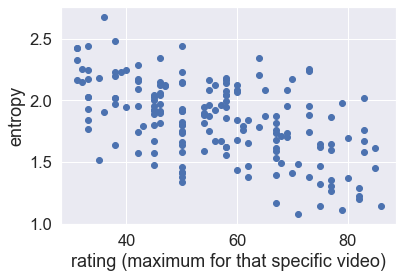

In [9]:
# example plot max value vs entropy for category Amusement
plt.scatter(category_df_included['max value'][category_df_included['max category']=='Amusement'],category_df_included['entropy'][category_df_included['max category']=='Amusement'])
plt.xlabel('rating (maximum for that specific video)');
plt.ylabel('entropy');
print('We want those videos with low entropy and high rating (lower-right corner)')

In [10]:
# specify the video categories for the experiment
categories_of_interest = ['Calmness','Amusement','Sadness','Anxiety','Disgust']
# if not enough videos in category use those most similar categories:
backup_category = ['Aesthetic Adoration', 'Joy', 'Sympathy', 'Fear', 'Horror']
Ntrials = 100 # number of trials including first and second block of video clips
Nvideos_per_cat = int(Ntrials / len(categories_of_interest)); # number of videos per category

In [11]:
print(str(Nvideos_per_cat) + ' videos needed for each category!')
for i in range(len(categories_of_interest)):
    print(categories_of_interest[i], end=': ')
    print(sum((category_df_included['max category']==categories_of_interest[i])))

20 videos needed for each category!
Calmness: 5
Amusement: 174
Sadness: 28
Anxiety: 22
Disgust: 48


In [12]:
# choose the videos with max rating and min entropy within a category
Nvideos_per_cat = 30
finalVideoList = pd.DataFrame()
for k in range(len(categories_of_interest)):
    idx = category_df_included[category_df_included['max category']==\
                               categories_of_interest[k]].sort_values(['entropy','max value'], \
                                                        ascending = [True, False]).index.to_list()
    if len(idx) < Nvideos_per_cat:
        idx2 = category_df_included[category_df_included['max category']==\
                           backup_category[k]].sort_values(['entropy','max value'], \
                                                    ascending = [True, False]).index.to_list()
        idx = idx + idx2
    finalVideoList[categories_of_interest[k]] = category_df_included['videoID'].iloc[idx[:Nvideos_per_cat]].values
print(finalVideoList)

    Calmness Amusement   Sadness   Anxiety   Disgust
0   1835.mp4  0938.mp4  1959.mp4  1313.mp4  2018.mp4
1   1216.mp4  0740.mp4  0756.mp4  0046.mp4  1471.mp4
2   1760.mp4  1289.mp4  2035.mp4  0377.mp4  1123.mp4
3   0590.mp4  0741.mp4  0059.mp4  0489.mp4  0048.mp4
4   1716.mp4  1963.mp4  0067.mp4  0604.mp4  2019.mp4
5   0058.mp4  2061.mp4  1238.mp4  0329.mp4  2106.mp4
6   1988.mp4  2111.mp4  1101.mp4  0615.mp4  0551.mp4
7   0055.mp4  2039.mp4  2038.mp4  0722.mp4  0271.mp4
8   0636.mp4  1047.mp4  0700.mp4  0598.mp4  0865.mp4
9   1071.mp4  0416.mp4  1259.mp4  1657.mp4  0857.mp4
10  0084.mp4  1290.mp4  0009.mp4  0853.mp4  1414.mp4
11  0870.mp4  0728.mp4  0181.mp4  1297.mp4  0464.mp4
12  0969.mp4  0653.mp4  1231.mp4  0372.mp4  1122.mp4
13  1496.mp4  0503.mp4  1279.mp4  0096.mp4  0214.mp4
14  1132.mp4  2031.mp4  2011.mp4  1679.mp4  1268.mp4
15  2163.mp4  0625.mp4  1485.mp4  0045.mp4  1916.mp4
16  1195.mp4  0633.mp4  0104.mp4  0648.mp4  1309.mp4
17  0397.mp4  2182.mp4  0051.mp4  0985.mp4  21

In [13]:
# create two sets of videos for first and second block
catList = []
for j in range(int(Nvideos_per_cat/2)):
    for i in categories_of_interest:
        catList.append(i)
        
df_finalVideoList = {'videoset1': finalVideoList.iloc[np.arange(1,Nvideos_per_cat,2)].values.flatten(),\
                    'videoset2': finalVideoList.iloc[np.arange(0,Nvideos_per_cat,2)].values.flatten(), \
                    'category': catList}
df_finalVideoList = pd.DataFrame(df_finalVideoList)
# df_finalVideoList = df_finalVideoList.sample(frac=1)

In [14]:
# show x video clips y times instead of just once in each set (same category)
x = 2
y = 3
repeat_videos = df_finalVideoList.sample(x)
df_finalVideoList = pd.concat((df_finalVideoList, \
                               pd.DataFrame(np.repeat(repeat_videos.values, y-1, axis=0), \
                                            columns = df_finalVideoList.columns)),axis=0, ignore_index=True)
df_finalVideoList = df_finalVideoList.sample(frac=1)

In [16]:
# save videolist for experiment
# df_finalVideoList.to_csv(filepath + 'prep/videosForExperiment.csv')
# with io.open(filepath + 'prep/videosForExperiment.js', 'w', encoding='utf-8') as f:
#     f.write('var video_set = ' + str([df_finalVideoList['videoset1'].values.tolist(),\
#                                       df_finalVideoList['videoset2'].values.tolist()]))

In [17]:
# choose trials for attention check (10% of the trials)
Nattentionchecks = int(np.ceil(Ntrials * 0.1))
attentionchecktrials = sample(list(np.arange(Ntrials)), Nattentionchecks)
fix_trials = attentionchecktrials[:int(np.ceil(len(attentionchecktrials)/2))]
check_trials = attentionchecktrials[int(np.ceil(len(attentionchecktrials)/2)):]
print(fix_trials, check_trials)
# save attention check list for experiment
# with io.open(filepath + 'prep/attentionchecks.js', 'w', encoding='utf-8') as f:
#     f.write('var fix_trials = '+ str(fix_trials) + '\nvar check_trials = ' + str(check_trials))

[93, 22, 99, 20, 98] [46, 68, 14, 58, 70]


All videos were reviewed to ensure that they are suitable for the experiment. Some videos were excluded for a particular reason, as noted in the file: /experiement/public/prep/VideosForExperiment_checked.xlsx

In [15]:
#load final video list to replicate figures below
df_finalVideoList = pd.read_csv(filepath + 'prep/videosForExperiment.csv')

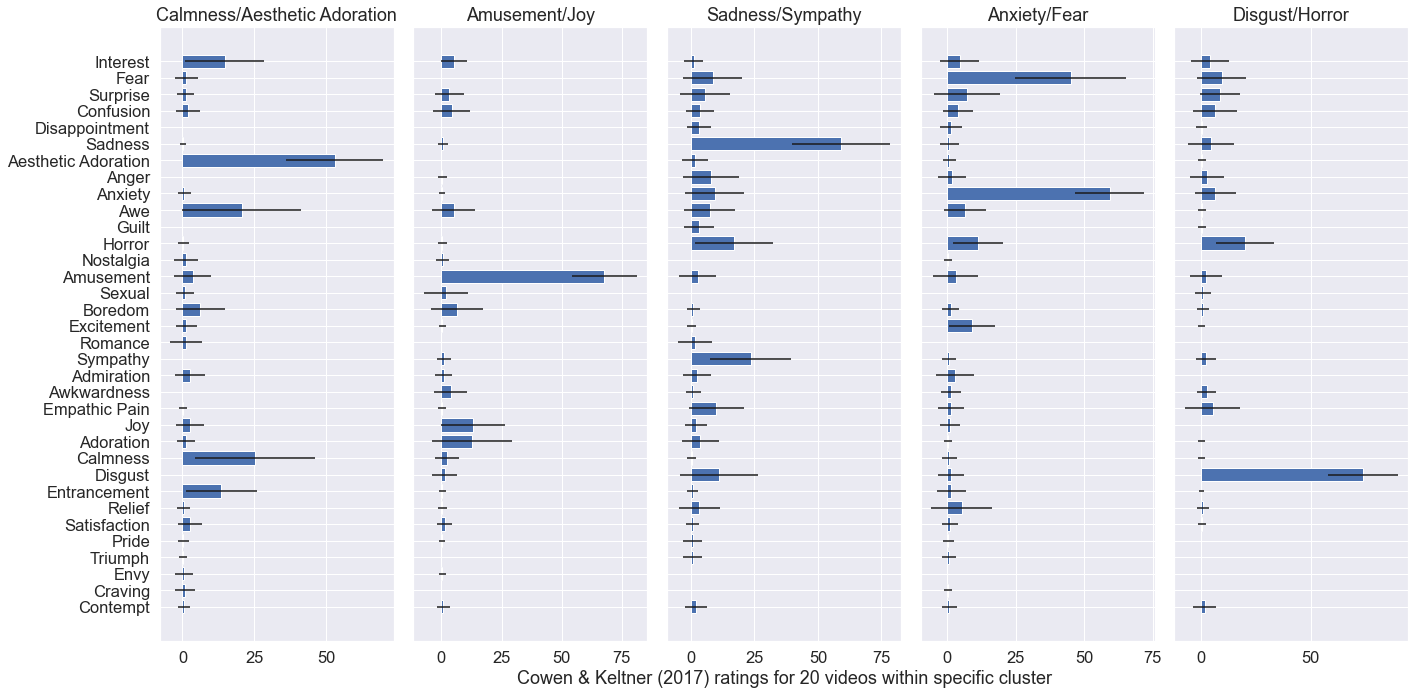

In [16]:
# plot mean and std rating for videos within a category
df_finalVideoList = pd.read_csv(filepath + 'prep/videosForExperiment.csv')
fig, axs = plt.subplots(1,len(categories_of_interest),figsize=[20,10])
for k in range(len(categories_of_interest)):
    idx = category_df_included[category_df_included['max category']==\
                               categories_of_interest[k]].sort_values(['entropy','max value'], \
                                                        ascending = [True, False]).index.to_list()
    if len(idx) < Nvideos_per_cat:
        idx2 = category_df_included[category_df_included['max category']==\
                           backup_category[k]].sort_values(['entropy','max value'], \
                                                    ascending = [True, False]).index.to_list()
        idx = idx + idx2
        
    m = category_df_included[video_categories].iloc[idx[:Nvideos_per_cat]].mean()
    e = category_df_included[video_categories].iloc[idx[:Nvideos_per_cat]].std()
    axs[k].barh(np.arange(0,34),m, xerr=e)
#     axs[k].grid(zorder=0);
    if k == 2: 
        axs[k].set_xlabel('Cowen & Keltner (2017) ratings for 20 videos within specific cluster');
    axs[k].set_yticks(np.arange(0,34));
    if k == 0:
        axs[k].set_yticks(np.arange(0,34));
        axs[k].set_yticklabels(video_categories, rotation=0);
    else:
        axs[k].set_yticklabels([]);
            
    axs[k].set_title(categories_of_interest[k] + '/' + backup_category[k])
    axs[k].invert_yaxis()
fig.tight_layout()
plt.savefig('../results/figures/video_cluster_ratings.png')

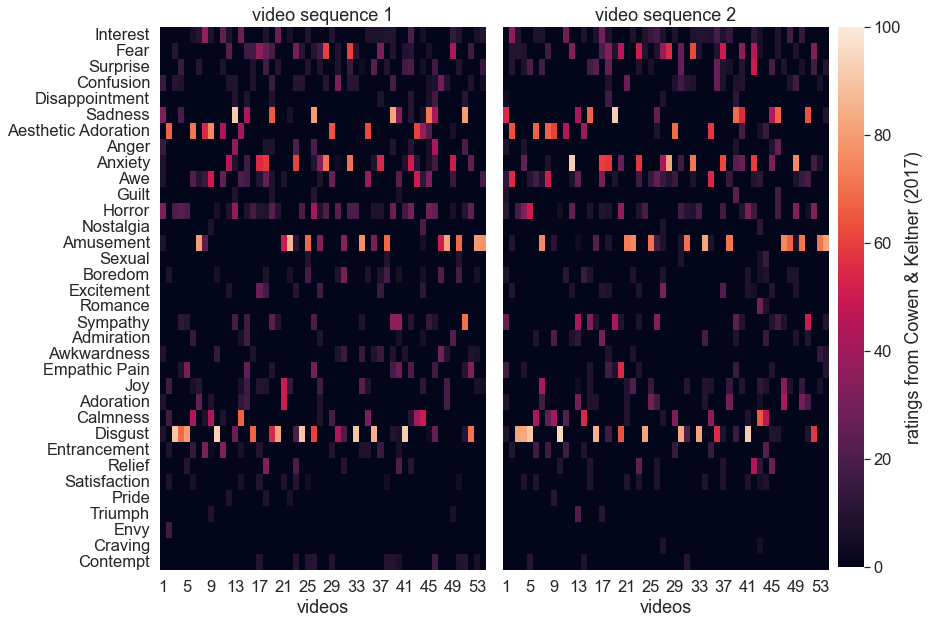

In [18]:
df_finalVideoList = pd.read_csv(filepath + 'prep/videosForExperiment.csv')
fig,ax = plt.subplots(1,2,figsize=(12,10), gridspec_kw={'wspace': 0.05})
for i in range(1,3):
    rating_list = []
    for j in range(len(df_finalVideoList['videoset' + str(i)])):
        rating_list.append(category_df_included[video_categories]\
                           [category_df_included['videoID'] \
                            == df_finalVideoList['videoset' + str(i)][j]].values)
    if i == 1: 
        show_cbar = False
        cbar_ax = None
    else: 
        show_cbar = True
        cbar_ax = fig.add_axes([.91, 0.13, .03, 0.75])

    b = sns.heatmap(np.array(rating_list).reshape(np.shape(rating_list)[0],len(video_categories)).T, \
                yticklabels=video_categories,xticklabels=range(1,np.shape(rating_list)[0]+1), ax=ax[i-1], vmax=100, \
                    cbar=show_cbar, cbar_ax = cbar_ax, cbar_kws={'label': 'ratings from Cowen & Keltner (2017)'})
    b.set_title('video sequence ' + str(i))
    b.set_xlabel('videos')
    if i == 1: b.set_yticklabels(video_categories, rotation=0)
    else: b.set_yticklabels([])
    b.set_xticklabels(b.get_xticklabels(), rotation=0)
    [l.set_visible(False) for (i,l) in enumerate(b.get_xticklabels()) if i % 4 != 0]
plt.savefig('../results/figures/video_selection_all.png', bbox_inches='tight')